In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
os.chdir('C:/Users/wissam_T/Desktop/5th/2nd semester/ml + dm')

In [4]:
og_vehicles_df = pd.read_csv("data/vehicles.csv")

In [5]:
og_vehicles_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [6]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(og_vehicles_df, test_size=0.2, random_state=42)

In [7]:
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

In [8]:
cols_to_drop = ['id', 'url', 'region_url', 'county', 'image_url', 'posting_date', 'VIN']

In [82]:
train_copy = train.copy()

In [83]:
train_copy = train_copy.drop(columns = cols_to_drop)

# filling null values using the model column 

In [84]:
# Step 1: Group by model and calculate mode (most common values) for categorical columns
model_based_fill = train_copy.groupby('model').agg({
    'manufacturer': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'cylinders': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'fuel': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'transmission': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'drive': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'size': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'year': lambda x: x.mode()[0] if not x.mode().empty else np.nan,    
}).reset_index()

# Step 2: Merge with original data to fill nulls
for col in ['manufacturer', 'cylinders', 'fuel',
           'transmission', 'drive', 'size', 'type', 'year']:
    train_copy[col] = train_copy[col].fillna(train_copy.merge(model_based_fill, on='model', how='left')[f'{col}_y'])

In [85]:
train_copy.isna().sum()

region               0
price                0
year               129
manufacturer      4173
model             3363
condition       111496
cylinders        49026
fuel               811
odometer          2852
title_status      5262
transmission       613
drive            32349
size             99209
type             21947
paint_color      83422
description         50
state                0
lat               4135
long              4135
dtype: int64

In [86]:
train.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year               784
manufacturer     11267
model             3363
condition       111496
cylinders       113755
fuel              1895
odometer          2852
title_status      5262
transmission      1613
VIN             103167
drive            83590
size            196012
type             59646
paint_color      83422
image_url           49
description         50
county          273203
state                0
lat               4135
long              4135
posting_date        49
dtype: int64

In [87]:
electric_cars_df = train_copy[train_copy['fuel'] == 'electric']

In [88]:
electric_cars_df.isna().sum()

region            0
price             0
year              0
manufacturer     15
model             1
condition       363
cylinders       374
fuel              0
odometer          4
title_status     18
transmission      5
drive            71
size            426
type             31
paint_color     303
description       0
state             0
lat              20
long             20
dtype: int64

# Since electric vehicles dont have cylinders we'll just put "0" in the column

In [90]:
train_copy.loc[train_copy['fuel'] == 'electric', 'cylinders'] = 0

In [91]:
train_copy.isna().sum()

region               0
price                0
year               129
manufacturer      4173
model             3363
condition       111496
cylinders        48652
fuel               811
odometer          2852
title_status      5262
transmission       613
drive            32349
size             99209
type             21947
paint_color      83422
description         50
state                0
lat               4135
long              4135
dtype: int64

# Using information from the description to fill null values

In [94]:
train_copy['description'].head()

298217                      All wheel drive well maintained
108574    Any year, make, model, and in any condition. W...
69187     Jeep Rubicon---24,216 miles. Probably like you...
168535    Carvana is the safer way to buy a car During t...
16825     Toyota fj 2007 new km2 tires cold a/c 4x4 led ...
Name: description, dtype: object

In [103]:
import re

def extract_mileage(description):
    if pd.isna(description):
        return None
    patterns = [
        r'(\d{1,3}(?:,\d{3})*)\s*miles',  # 85,000 miles
        r'(\d{1,3}(?:,\d{3})*)\s*mi',     # 120,000 mi
        r'(\d+)\s*k\s*miles',              # 120k miles
        r'(\d+)\s*k\s*mi',                 # 85k mi
        r'(\d+)\s*k\b'                     # 120k
    ]
    for pattern in patterns:
        match = re.search(pattern, description.lower())
        if match:
            mileage = match.group(1).replace(',', '')
            return int(mileage) * 1000 if 'k' in match.group(0) else int(mileage)
    return None

In [104]:
def extract_transmission(description):
    if pd.isna(description):
        return None
    transmission_map = {
        'automatic': ['auto', 'automatic'],
        'manual': ['manual', 'stick'],
        'cvt': ['cvt'],
        'dual-clutch': ['dual clutch', 'dsg']
    }
    desc = description.lower()
    for trans_type, keywords in transmission_map.items():
        if any(keyword in desc for keyword in keywords):
            return trans_type
    return None

In [105]:
def extract_drive_type(description):
    if pd.isna(description):
        return None
    drive_map = {
        'fwd': ['front wheel', 'fwd'],
        'rwd': ['rear wheel', 'rwd'],
        'awd': ['all wheel', 'awd', '4matic', 'quattro'],
        '4wd': ['four wheel', '4wd', '4x4']
    }
    desc = description.lower()
    for drive_type, keywords in drive_map.items():
        if any(keyword in desc for keyword in keywords):
            return drive_type
    return None

In [120]:
import re
from collections import defaultdict

# Expanded color dictionary with common variants
color_map = defaultdict(list, {
    'white': ['white', 'pearl', 'ivory', 'alabaster'],
    'black': ['black', 'onyx', 'ebony', 'obsidian'],
    'silver': ['silver', 'platinum', 'metallic gray', 'light grey'],
    'gray': ['gray', 'grey', 'graphite', 'charcoal', 'dark grey'],
    'red': ['red', 'ruby', 'burgundy', 'cherry', 'scarlet', 'maroon'],
    'blue': ['blue', 'navy', 'sapphire', 'aqua', 'teal'],
    'green': ['green', 'emerald', 'forest', 'lime', 'mint'],
    'brown': ['brown', 'tan', 'bronze', 'copper', 'champagne', 'mocha'],
    'gold': ['gold', 'amber'],
    'yellow': ['yellow', 'mustard']
})

def extract_paint_color(description):
    if pd.isna(description):
        return None
    desc = description.lower()
    for color, variants in color_map.items():
        if any(variant in desc for variant in variants):
            return color
    return None

In [122]:
vehicle_type_map = {
    'sedan': ['sedan', 'saloon'],
    'SUV': ['suv', 'sport utility', 'crossover', 'jeep'],
    'truck': ['truck', 'pickup', 'pick-up', 'ute'],
    'coupe': ['coupe', 'coupé', '2-door'],
    'hatchback': ['hatchback', 'hatch', 'liftback'],
    'wagon': ['wagon', 'estate'],
    'van': ['van', 'minivan', 'mpv'],
    'convertible': ['convertible', 'cabriolet', 'drop top', 'soft top']
}

def extract_vehicle_type(description):
    if pd.isna(description):
        return None
    desc = description.lower()
    for v_type, keywords in vehicle_type_map.items():
        if any(keyword in desc for keyword in keywords):
            return v_type
    return None

In [123]:
def extract_size(description):
    if pd.isna(description):
        return None
    # Look for size indicators
    size_patterns = [
        (r'\bfull[\s\-]?size\b', 'full'),
        (r'\bmid[\s\-]?size\b', 'mid-size'),
        (r'\bcompact\b', 'compact'),
        (r'\bsubcompact\b', 'subcompact'),
        (r'\bmini\b', 'subcompact'),
        (r'\b\d\.\dL\b', 'large')  # Large engine hint
    ]
    desc = description.lower()
    for pattern, size in size_patterns:
        if re.search(pattern, desc):
            return size
    return None

In [121]:
def extract_cylinders(description):
    if pd.isna(description):
        return None
    # Patterns like "V6", "4 cyl", "6 cylinder"
    patterns = [
        (r'\b(v\d)\b', lambda m: m.group(1)[1] + ' cylinders'),  # V6
        (r'\b(\d)\s*(cyl|cylinder)\b', lambda m: f"{m.group(1)} cylinders"),  # 4 cyl
        (r'\b(\d)\s*[\-]?speed\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4,6,8] else None),
        (r'\b(\d\.\d)L\b', lambda m: '6 cylinders' if float(m.group(1)) >= 3.0 else '4 cylinders')
    ]
    desc = description.lower()
    for pattern, group in patterns:
        match = re.search(pattern, desc)
        if match:
            cylinders = int(match.group(group))
            return f'{cylinders} cylinders' if cylinders > 4 else f'{cylinders} cylinders'
    return None

In [124]:
def extract_fuel(description):
    if pd.isna(description):
        return None
    fuel_map = {
        'gas': ['gas', 'gasoline', 'petrol'],
        'diesel': ['diesel'],
        'electric': ['electric', 'ev'],
        'hybrid': ['hybrid', 'plug-in hybrid', 'phev'],
        'other': ['flex fuel', 'ethanol', 'lpg']
    }
    desc = description.lower()
    for fuel_type, keywords in fuel_map.items():
        if any(keyword in desc for keyword in keywords):
            return fuel_type
    return None

In [125]:
def extract_manufacturer(description):
    if pd.isna(description):
        return None
    # Top brands
    brands = ['toyota', 'honda', 'ford', 'chevrolet', 'chevy', 'nissan', 'bmw', 'mercedes', 'mazda', 'jeep',
              'subaru', 'hyundai', 'kia', 'audi', 'vw', 'volkswagen', 'dodge', 'ram', 'gmc', 'lexus', 'chrysler']
    desc = description.lower()
    for brand in brands:
        if brand in desc:
            if brand == 'chevy':
                return 'chevrolet'
            elif brand == 'vw':
                return 'volkswagen'
            else:
                return brand
    return None

In [126]:
def extract_year(description):
    if pd.isna(description):
        return None
    match = re.search(r'\b(19[8-9]\d|20[0-4]\d|2025)\b', description)
    if match:
        return int(match.group(1))
    return None

In [127]:
def safe_extract(row, col):
    try:
        desc = row['description']
        if col == 'odometer':
            return extract_mileage(desc)
        elif col == 'transmission':
            return extract_transmission(desc)
        elif col == 'drive':
            return extract_drive_type(desc)
        elif col == 'paint_color':
            return extract_paint_color(desc)
        elif col == 'type':
            return extract_vehicle_type(desc)
        elif col == 'size':
            return extract_size(desc)
        elif col == 'cylinders':
            return extract_cylinders(desc)
        elif col == 'fuel':
            return extract_fuel(desc)
        elif col == 'manufacturer':
            return extract_manufacturer(desc)
        elif col == 'year':
            return extract_year(desc)
        else:
            return None
    except Exception:
        return None


In [128]:
columns_to_fill = [
    'odometer', 'transmission', 'drive', 'paint_color', 
    'type', 'size', 'cylinders', 'fuel', 'manufacturer', 'year'
]

for col in columns_to_fill:
    mask = train_copy[col].isna()
    train_copy.loc[mask, col] = train_copy[mask].apply(lambda row: safe_extract(row, col), axis=1)


In [129]:
train_copy.isna().sum()

region                         0
price                          0
year                          16
manufacturer                1876
model                       3363
condition                 111496
cylinders                  32189
fuel                         107
odometer                    1331
title_status                5262
transmission                  22
drive                      16223
size                       88346
type                        9528
paint_color                17397
description                   50
state                          0
lat                         4135
long                        4135
extracted_mileage         102661
extracted_transmission     56660
extracted_drive            97260
extracted_color            51904
extracted_type             72473
extracted_size            250441
extracted_cylinders       185480
dtype: int64

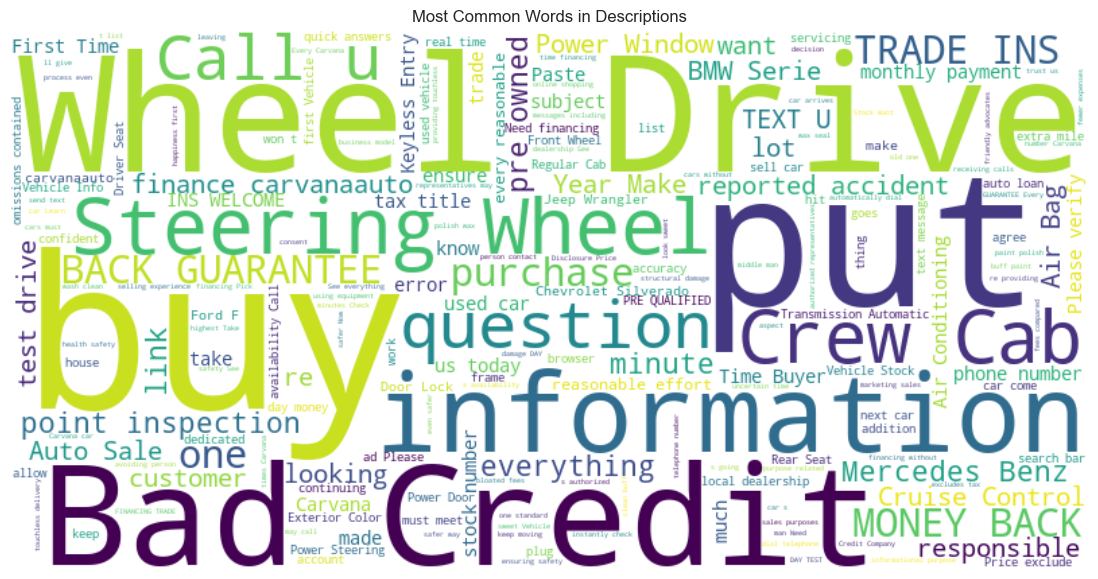

In [117]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(train_copy['description'].dropna().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Descriptions")
plt.show()